In [63]:
import imageio.v3 as iio
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import math
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import ndimage, spatial
from segmentflow import segment, view
from skimage import exposure, filters, measure, morphology, segmentation
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This notebook adds to the segmentation routine of an SEM back-scattered
electron image of IDOX-Estane (collected by Nate Peterson at Colorado
School of Mines) developed in the "Figures" section of NB 42.
In this updated version, subpixel boundaries are used to set the region
boundaries such that regions will be in contacted when meshed for an FEM
simulation.

## Loading

(481, 555)
(481, 555)


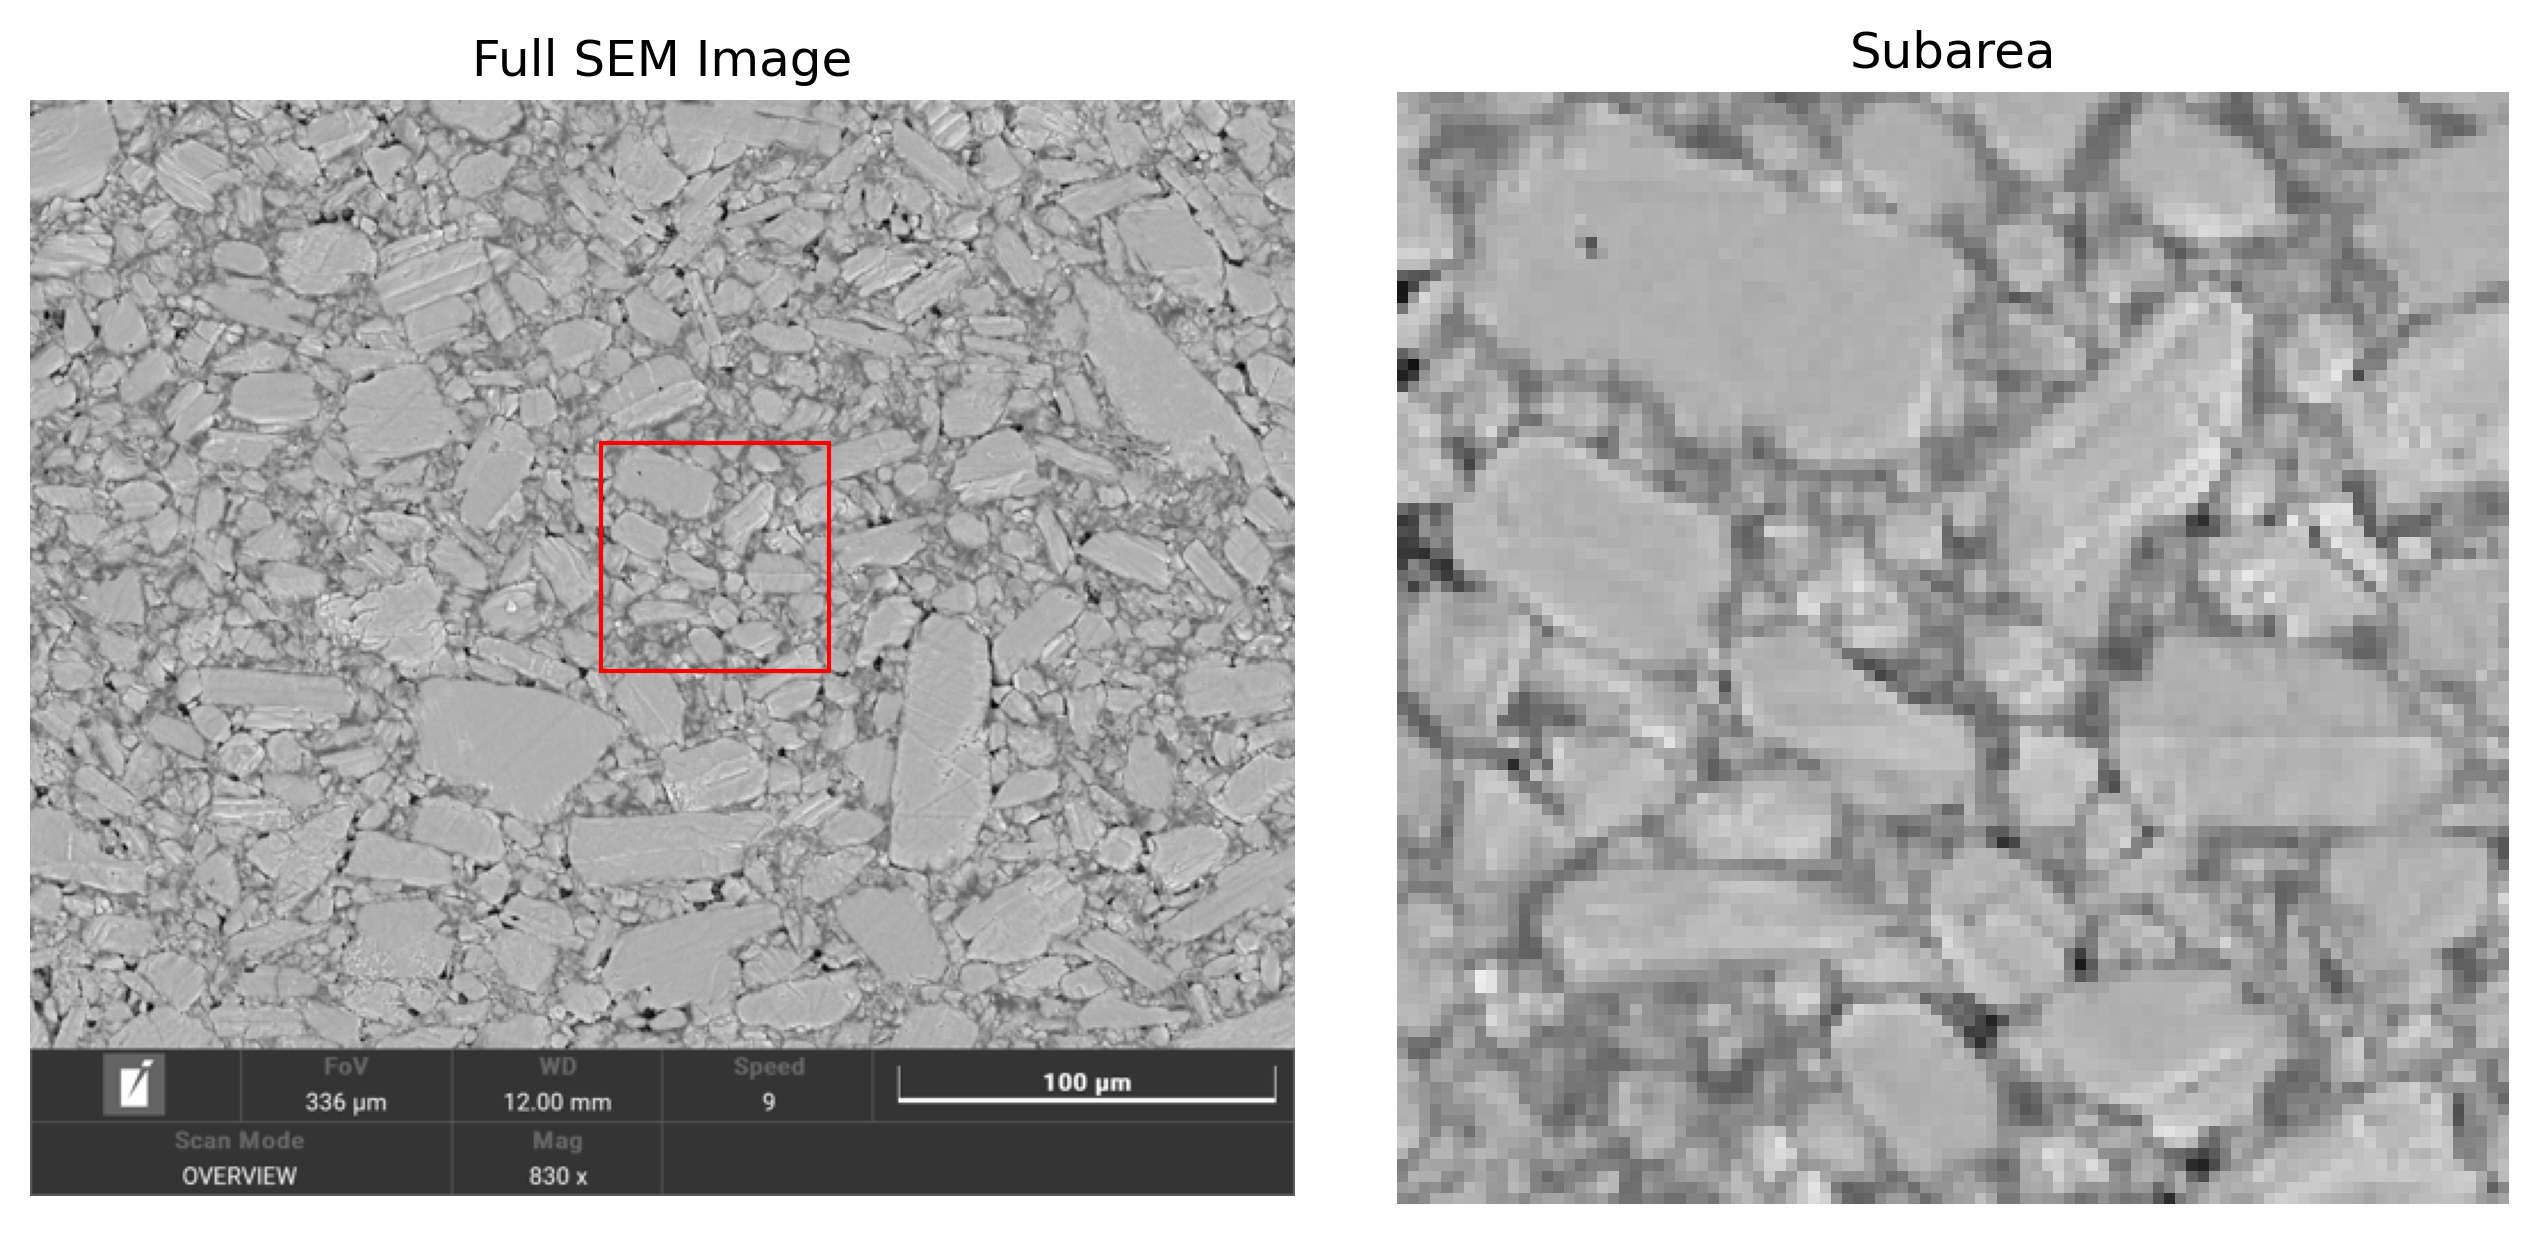

In [3]:
# %matplotlib qt
%matplotlib inline
img_dir_path = Path('../data/sem_idox_estane2.tif')
img = iio.imread(img_dir_path)
print(img.shape)
# img = img[:400, :]
print(img.shape)
fig, axes = plt.subplots(
    1, 2, dpi=300, facecolor='white', figsize=(8.6, 4),
    constrained_layout=True)
axes[0].imshow(img, vmin=img.min(), vmax=img.max(), cmap='gray')
row_crop = [150, 250]
col_crop = [250, 350]
rect = patches.Rectangle(
    (col_crop[0], row_crop[0]),
    col_crop[1]-col_crop[0], row_crop[1]-row_crop[0],
    linewidth=1, edgecolor='r', facecolor='none')
axes[0].add_patch(rect)
axes[0].set_title('Full SEM Image')
img_crop = img[row_crop[0]:row_crop[1], col_crop[0]:col_crop[1]]
axes[1].imshow(img_crop, vmin=img.min(), vmax=img.max(), cmap='gray')
axes[1].set_title('Subarea')
for a in axes:
    a.set_axis_off()

## Semantic segmentation

--> Void area fraction: 0.0077
--> Crystal area fraction: 0.8478
--> Crystal area fraction (void corrected): 0.8543787161140785


Text(0.5, 1.0, 'Isolated Classes')

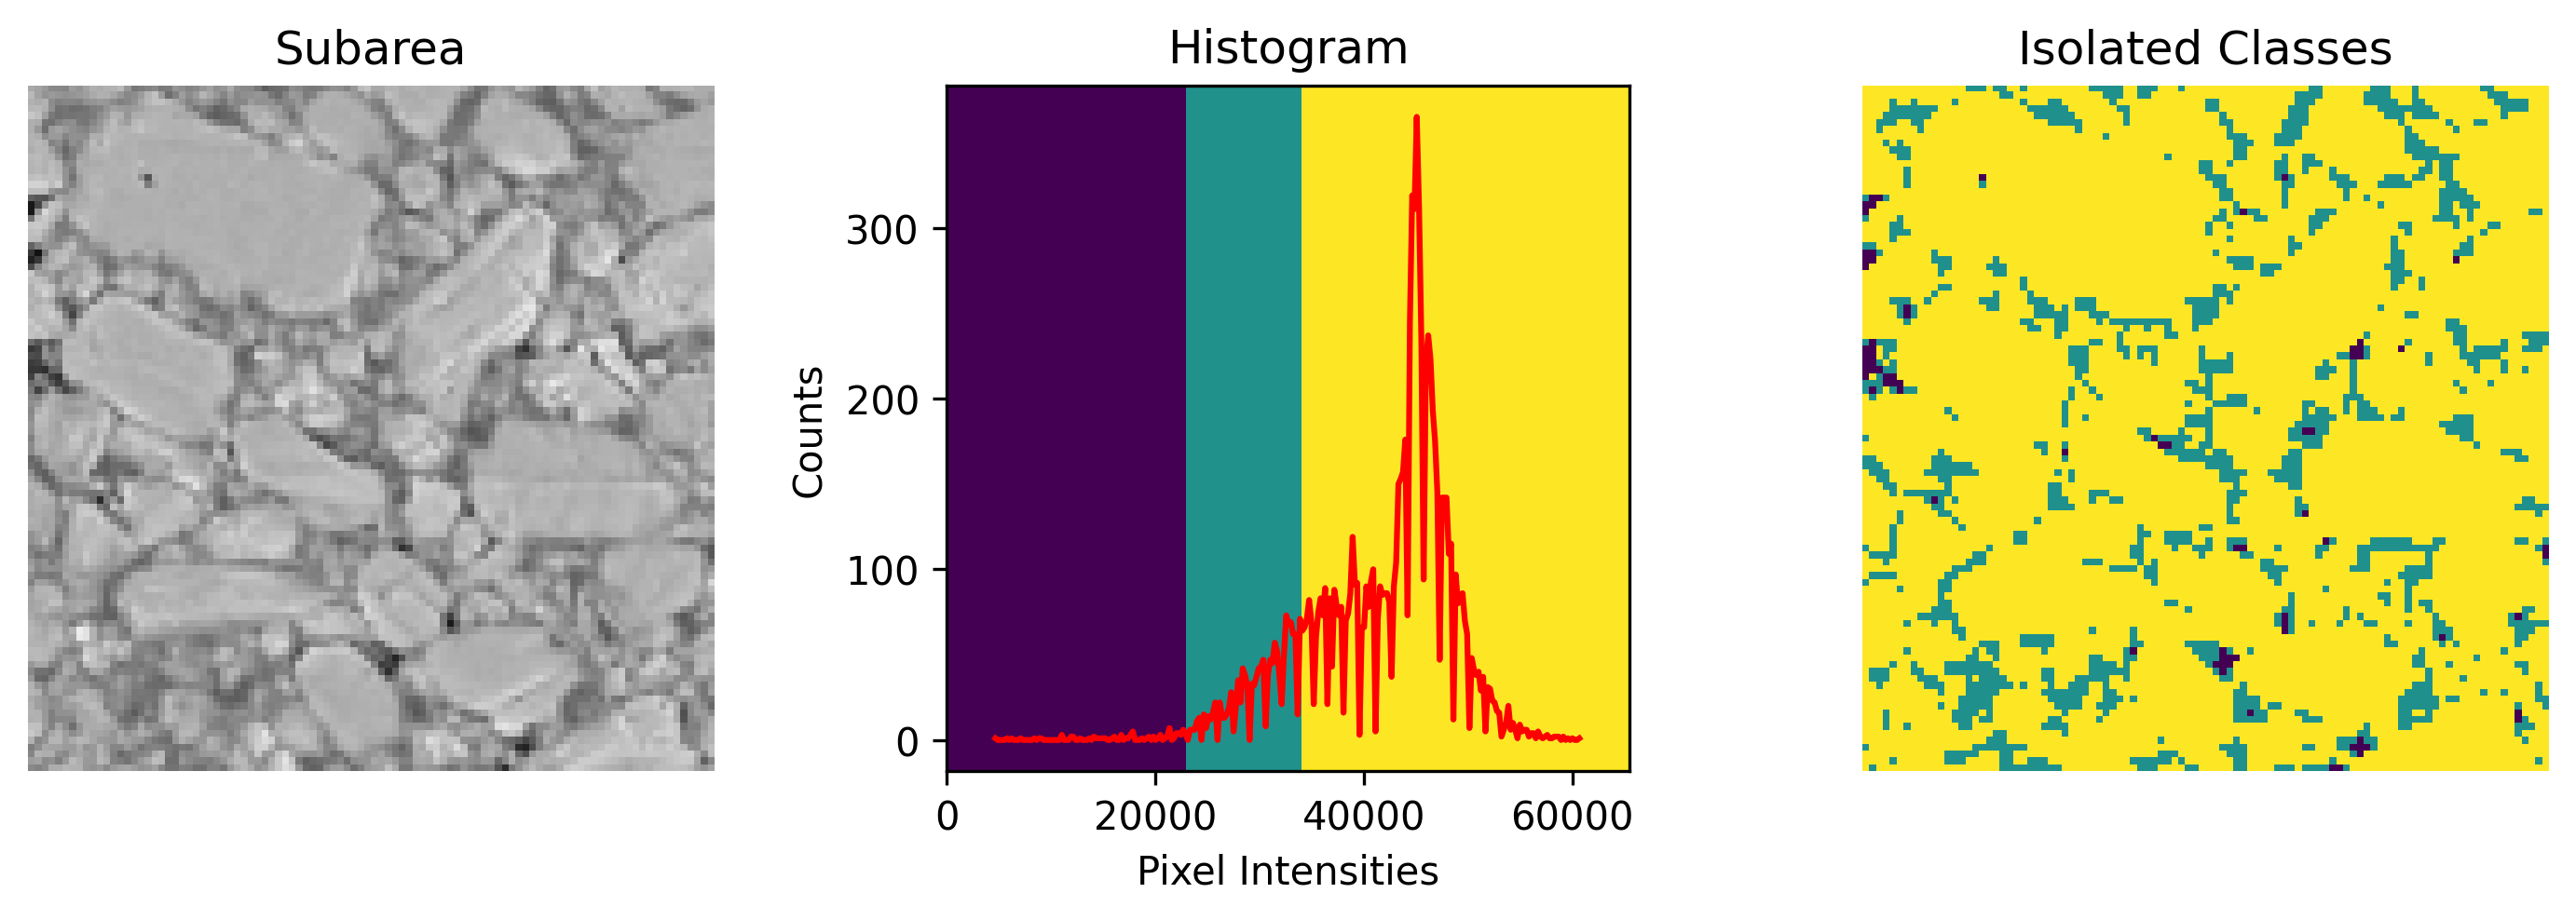

In [4]:
thresh_vals_man = [23000, 34000]
hist, bins_edges = np.histogram(img_crop, bins=256)
img_sem_man = segment.isolate_classes(img_crop, thresh_vals_man, intensity_step=1)
img_labeled = img_sem_man
n_pixels = img_labeled.shape[0] * img_labeled.shape[1]
n_void = np.count_nonzero(img_labeled == 0)
n_binder = np.count_nonzero(img_labeled == 1)
n_crystals = np.count_nonzero(img_labeled == 2)
print('--> Void area fraction:', n_void / n_pixels)
print('--> Crystal area fraction:', n_crystals / n_pixels)
print('--> Crystal area fraction (void corrected):', n_crystals / (n_pixels - n_void))
fig, axes = plt.subplots(
    1, 3, dpi=300, facecolor='white', figsize=(12, 3.25),
    constrained_layout=False)
axes[0].imshow(img_crop, vmin=img.min(), vmax=img.max(), cmap='gray')
axes[0].set_axis_off()
axes[0].set_title('Subarea')
axes[1].plot(bins_edges[:-1], hist, c='red', zorder=1)
colors = mpl.cm.get_cmap('viridis')
norm = mpl.colors.Normalize(vmin=0, vmax=2)
span_vals = [0] + thresh_vals_man + [2**16]
for i in range(0, len(span_vals)-1):
    axes[1].axvspan(span_vals[i], span_vals[i + 1], facecolor=colors(norm(i)), zorder=0)
    # axes[1].axvline(span_vals[i], c='red', zorder=2)
axes[1].set_xlim([0, 2**16])
axes[1].set_aspect(2**16/400)
axes[1].set_ylabel('Counts')
axes[1].set_xlabel('Pixel Intensities')
axes[1].set_title('Histogram')
axes[2].imshow(img_sem_man)
axes[2].set_axis_off()
axes[2].set_title('Isolated Classes')

## Instance segmentation

In [31]:
%matplotlib qt
img_labeled = segment.watershed_segment(img_sem_man==2, min_peak_distance=2)
# img_labeled[0, 18] = 0
# img_labeled[0, 21] = 0
# img_labeled[0, 22] = 0
# img_labeled[1, 22] = 0
# img_labeled[0, 37:46] = 0
# cleared_labeled = segmentation.clear_border(img_labeled)
img_colors = view.color_labels(img_labeled, return_image=True)
# fig, axes = view.images(
#     [img_crop, color_labeled, img_cleared, color_cleared], imgs_per_row=3, dpi=300)
fig, axes = view.images(
    [img_crop, img_labeled, img_colors], imgs_per_row=3, dpi=300)

Segmenting images...
--> Segmentation complete. 154 particle(s) segmented.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


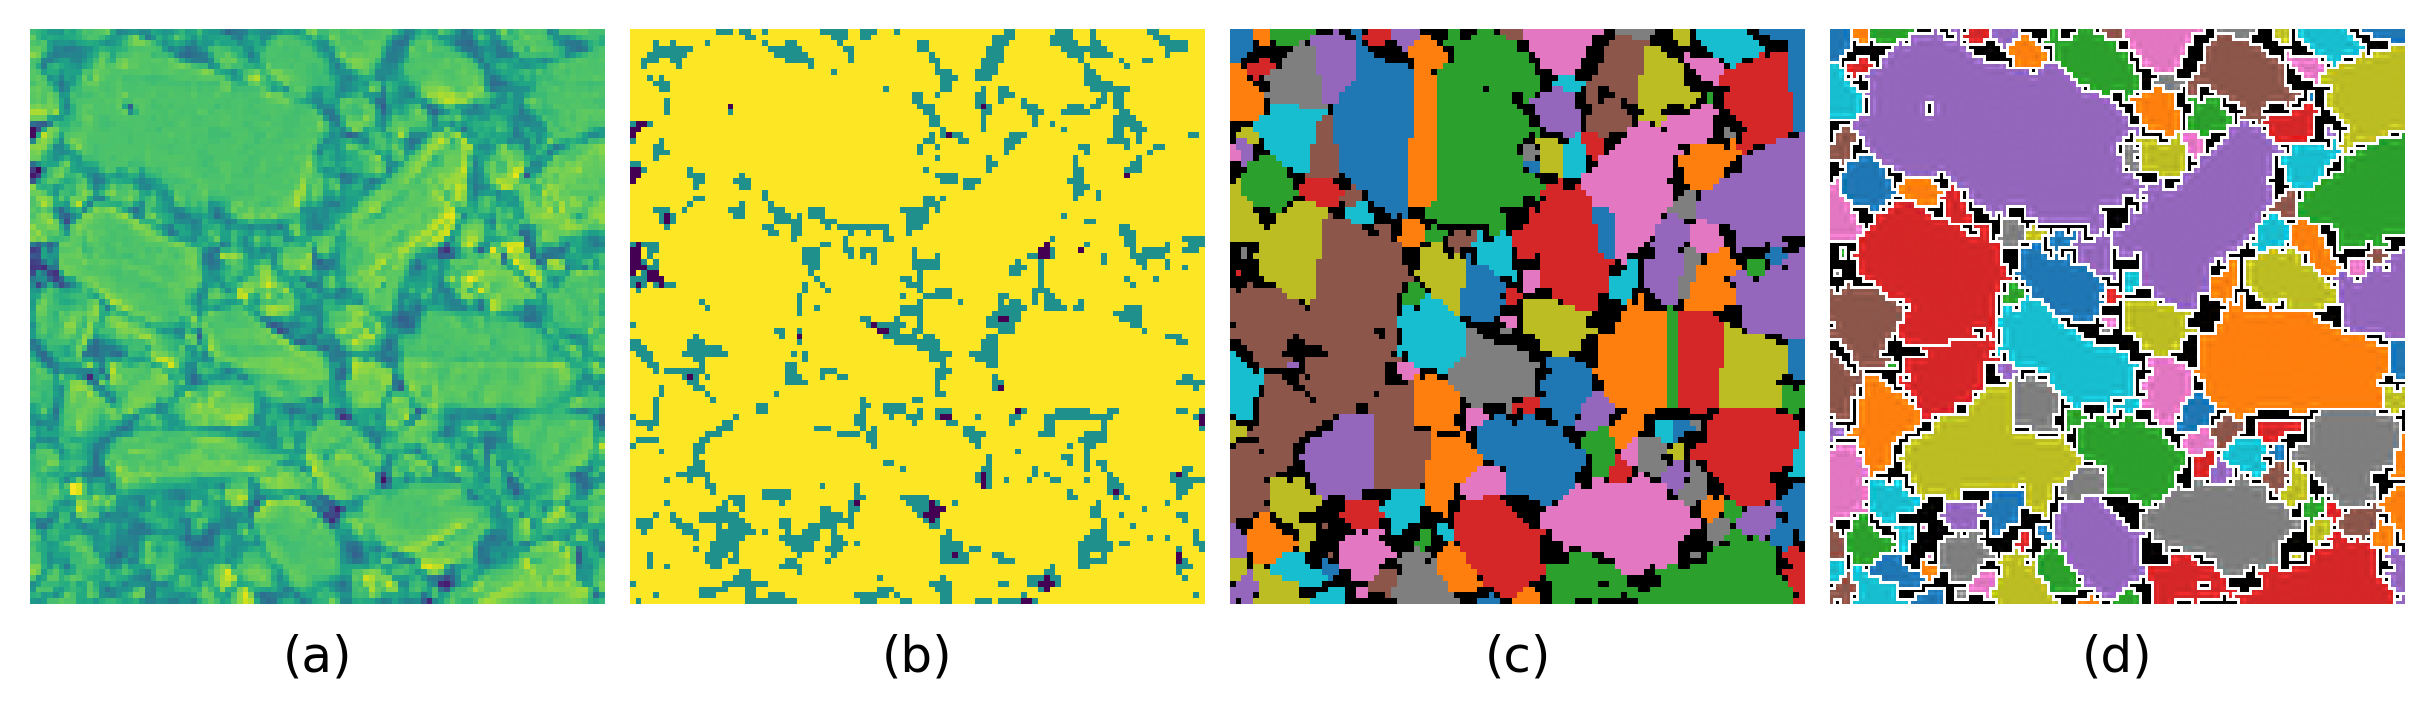

In [33]:
%matplotlib inline
merge_groups = [
    [15, 18, 30, 31, 32, 33, 36],
    [16, 19],
    [21, 24],
    [29, 35, 37],
    [38, 41],
    [39, 40],
    [47, 51, 54],
    [57, 62],
    [65, 68, 72],
    [82, 83, 84, 89],
    [46, 50],
    [59, 66],
    [69, 71],
    [80, 88],
    [105, 106, 112],
    [98, 100, 101],
    [107, 108],
]
merge_labeled = img_labeled.copy()
# merge_labeled = np.zeros_like(img_labeled)
for merge in merge_groups:
    for label in merge:
        merge_labeled[img_labeled == label] = merge[0]
merge_colors = view.color_labels(merge_labeled, return_image=True)
fig, ax = view.images(
    [
        img_crop,
        img_sem_man,
        img_colors,
        segmentation.mark_boundaries(merge_colors, merge_labeled, mode='subpixel', color=(1,1,1)),
    ], imgs_per_row=4, dpi=300, subplot_letters=True, fig_w=8)

## Boundary Extraction

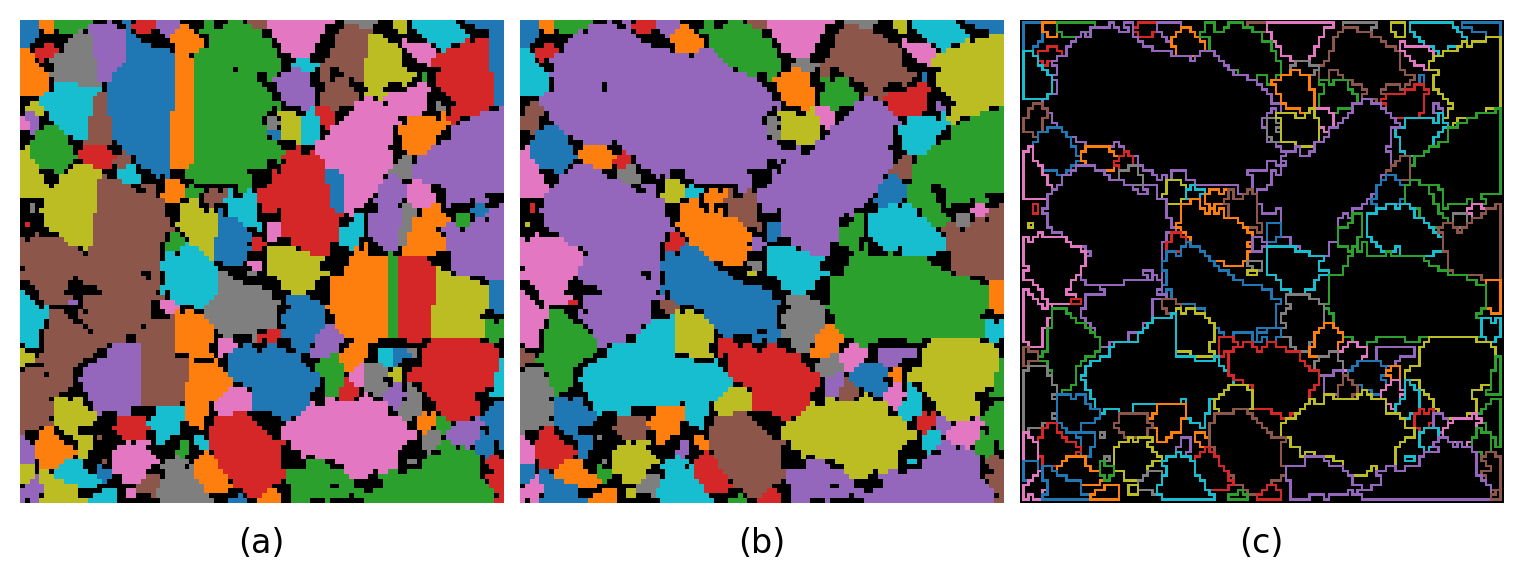

In [27]:
labels = np.unique(merge_labeled)
# Pad outer edge so find_boundaries returns coordinates along image borders
merge_labeled_padded = np.pad(merge_labeled, 1)
# Find boundaries around the regions
subpixel_bw = segmentation.find_boundaries(
    merge_labeled_padded, mode='subpixel').astype(np.ubyte)
subpixel_viz = np.zeros_like(subpixel_bw)
for i in labels[labels > 0]:
    # Isolate/binarize region label
    reg_bw = np.zeros_like(merge_labeled_padded)
    reg_bw[merge_labeled_padded == i] = 1
    # Fill holes to ensure all points are around the outer edge
    reg_bw = ndimage.binary_fill_holes(reg_bw).astype(np.ubyte)
    # Find subpixel boundaries
    subpixel_bounds = segmentation.find_boundaries(
        reg_bw, mode='subpixel').astype(np.ubyte)
    subpixel_viz[subpixel_bounds == 1] = i
fig, ax = view.images([
    img_colors,
    view.color_labels(merge_labeled, return_image=True),
    view.color_labels(subpixel_viz, return_image=True),
], imgs_per_row=3, dpi=200, subplot_letters=True)

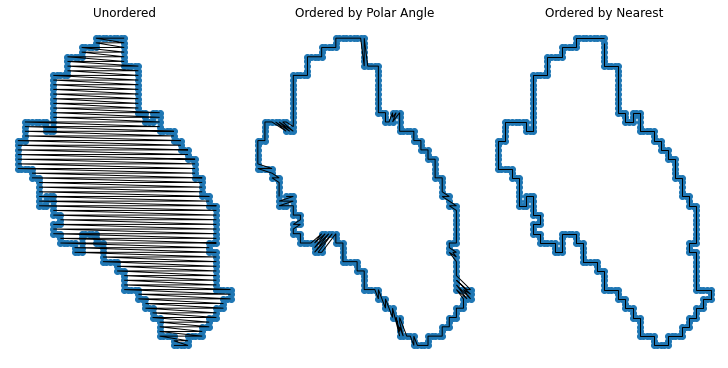

In [8]:
subpixel_bounds = segmentation.find_boundaries(
    merge_labeled == 47, mode='subpixel').astype(np.ubyte)
coords = np.transpose(np.nonzero(subpixel_bounds))
x = subpixel_bounds[:, 1]
y = subpixel_bounds[:, 0]
df = pd.DataFrame(data={'x': x, 'y': y})
fig, axes = plt.subplots(
    1, 3, figsize=(10, 5), constrained_layout=True, facecolor='white')
axes[0].scatter(coords[:, 1], coords[:, 0])
axes[0].add_patch(
    patches.Polygon(np.flip(coords), closed=False, fill=False))
axes[0].set_title('Unordered')
# Compute centroid
cent=(sum(coords[:, 1])/len(coords), sum(coords[:, 0])/len(coords))

# Sort by polar angle
ordered = np.array(
    sorted(coords, key=lambda p: math.atan2(p[0]-cent[1], p[1]-cent[0])))
ordered_loop = np.zeros((ordered.shape[0] + 1, 2))
ordered_loop[-1, :] = ordered[0, :]
ordered_loop[:-1, :] = ordered
# Plot polar ordered points
axes[1].scatter(ordered[:, 1], ordered[:, 0])
axes[1].add_patch(
    patches.Polygon(np.flip(ordered_loop), closed=False, fill=False))
axes[1].set_title('Ordered by Polar Angle')

# Order points by nearest
loop_list = [tuple(coords[-1])]
not_added = list(map(tuple, coords[:-1]))
while len(loop_list) < coords.shape[0]:
    pt = tuple(loop_list[-1])
    distances = spatial.distance_matrix([pt], not_added)[0]
    nearest_i = np.argmin(distances)
    nearest_pt = not_added[nearest_i]
    not_added.pop(nearest_i)
    loop_list.append(nearest_pt)
loop_list.append(loop_list[0])
# Plot nearest ordered points
axes[2].scatter(coords[:, 1], coords[:, 0])
axes[2].add_patch(
    patches.Polygon(np.flip(loop_list), closed=False, fill=False))
axes[2].set_title('Ordered by Nearest')
for a in axes:
    a.set_axis_off()

## Smooth by removing hard corners

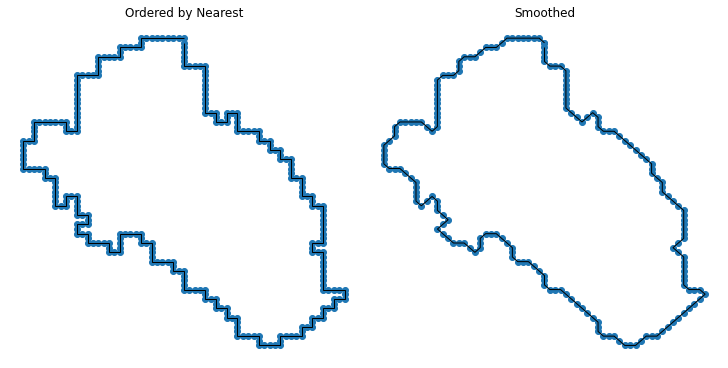

In [9]:
fig, axes = plt.subplots(
    1, 2, figsize=(10, 5), constrained_layout=True, facecolor='white')
# Plot nearest ordered points
axes[0].scatter(coords[:, 1], coords[:, 0])
axes[0].add_patch(
    patches.Polygon(np.flip(loop_list), closed=False, fill=False))
axes[0].set_title('Ordered by Nearest')

smooth_list = []
# Special case of the for loop below where pt before is actually the second to
# last in the list, since the first pt is repeated at the end of the list to
# make it a closed loop
if (
    spatial.distance.euclidean(loop_list[-2], loop_list[1])
    >= (
        spatial.distance.euclidean(loop_list[0], loop_list[-2])
        + spatial.distance.euclidean(loop_list[0], loop_list[1])
    )
):
    smooth_list.append(loop_list[0])
for i in range(1, len(loop_list) - 1):
    # If distance between pt before & pt after is larger or equal to the
    # the sum of the distance between the current pt & the pt before with the
    # distance between the current pt & the pt after, copy pt to smooth_list.
    # This means pts farther away than the surrounding pts are removed.
    if (
        spatial.distance.euclidean(loop_list[i - 1], loop_list[i + 1])
        >= (
            spatial.distance.euclidean(loop_list[i], loop_list[i - 1])
            + spatial.distance.euclidean(loop_list[i], loop_list[i + 1])
        )
    ):
        smooth_list.append(loop_list[i])
# Add first pt in list to the end to make it a closed loop
smooth_list.append(smooth_list[0])
smooth_coords = np.array(smooth_list)

# Plot smoothed points
axes[1].scatter(smooth_coords[:, 1], smooth_coords[:, 0])
axes[1].add_patch(
    patches.Polygon(np.flip(smooth_list), closed=False, fill=False))
axes[1].set_title('Smoothed')
for a in axes:
    a.set_axis_off()

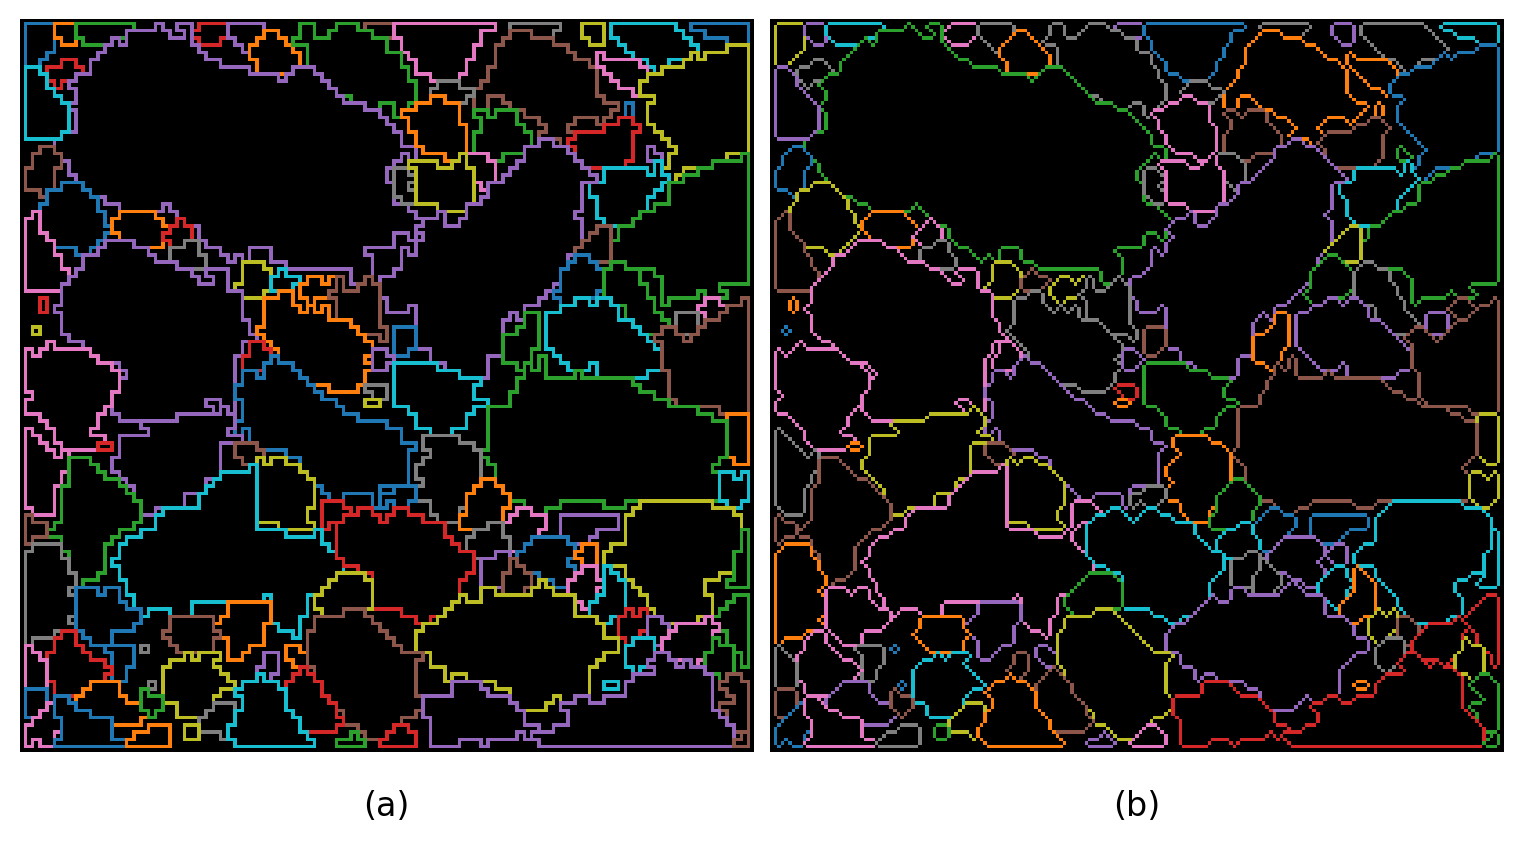

In [64]:
smooth_viz = np.zeros_like(subpixel_viz)
for i in labels[labels > 0]:
    # Isolate/binarize region label
    reg_bw = np.zeros_like(merge_labeled_padded)
    reg_bw[merge_labeled_padded == i] = 1
    # Fill holes to ensure all points are around the outer edge
    reg_bw = ndimage.binary_fill_holes(reg_bw).astype(np.ubyte)
    # Find subpixel boundaries
    subpixel_bounds = segmentation.find_boundaries(
        reg_bw, mode='subpixel').astype(np.ubyte)
    subpixel_viz[subpixel_bounds == 1] = i
    # Order bounding coordinates by nearest
    coords = np.transpose(np.nonzero(subpixel_bounds))
    # Order points by nearest
    loop_list = [tuple(coords[-1])]
    not_added = list(map(tuple, coords[:-1]))
    while len(loop_list) < coords.shape[0]:
        pt = tuple(loop_list[-1])
        distances = spatial.distance_matrix([pt], not_added)[0]
        nearest_i = np.argmin(distances)
        nearest_pt = not_added[nearest_i]
        not_added.pop(nearest_i)
        loop_list.append(nearest_pt)
    loop_list.append(loop_list[0])
    # Smooth regions
    smooth_list = []
    # Special case of the for loop below where pt before is actually the second to
    # last in the list, since the first pt is repeated at the end of the list to
    # make it a closed loop
    if (
        spatial.distance.euclidean(loop_list[-2], loop_list[1])
        >= (
            spatial.distance.euclidean(loop_list[0], loop_list[-2])
            + spatial.distance.euclidean(loop_list[0], loop_list[1])
        )
    ):
        smooth_list.append(loop_list[0])
    for i in range(1, len(loop_list) - 1):
        # If distance between pt before & pt after is larger or equal to the
        # the sum of the distance between the current pt & the pt before with the
        # distance between the current pt & the pt after, copy pt to smooth_list.
        # This means pts farther away than the surrounding pts are removed.
        if (
            spatial.distance.euclidean(loop_list[i - 1], loop_list[i + 1])
            >= (
                spatial.distance.euclidean(loop_list[i], loop_list[i - 1])
                + spatial.distance.euclidean(loop_list[i], loop_list[i + 1])
            )
        ):
            smooth_list.append(loop_list[i])
    # Add first pt in list to the end to make it a closed loop
    smooth_list.append(smooth_list[0])
    smooth_coords = np.array(smooth_list)
    smooth_viz[smooth_coords[:, 0], smooth_coords[:, 1]] = i
fig, ax = view.images([
    view.color_labels(subpixel_viz, return_image=True),
    view.color_labels(smooth_viz, return_image=True),
], imgs_per_row=2, dpi=200, subplot_letters=True)

## Scratch

In [68]:
len(labels[labels < 100])

77

In [66]:
labels

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  20,  21,  22,  23,  25,  26,  27,  28,
        29,  34,  38,  39,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        52,  53,  55,  56,  57,  58,  59,  60,  61,  63,  64,  65,  67,
        69,  70,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  85,
        86,  87,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 102,
       103, 104, 105, 107, 109, 110, 111, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144,
       145, 146, 147, 148, 149, 150, 151, 152, 153, 154], dtype=uint8)

In [13]:
pt = tuple(coords[-1])
print(f'{pt=}')
test =  list(map(tuple, coords[:10]))
print(f'{test=}')
distances = spatial.distance_matrix([pt], test)[0]
print(distances)
print(f'{np.argmin(distances)=}')
print(f'min pt: {test[np.argmin(distances)]}')
test.pop(np.argmin(distances))
print(f'{test=}')

pt=(97, 127)
test=[(31, 141), (31, 142), (31, 143), (31, 144), (31, 145), (32, 141), (32, 145), (33, 137), (33, 138), (33, 139)]
[67.46851117 67.68308504 67.91170739 68.15423685 68.41052551 66.49060084
 67.44627492 64.77653896 64.93843238 65.11528238]
np.argmin(distances)=7
min pt: (33, 137)
test=[(31, 141), (31, 142), (31, 143), (31, 144), (31, 145), (32, 141), (32, 145), (33, 138), (33, 139)]
